# Sandbox
Notebook to test code before real implementation

In [ ]:
################ ONLY PYTHON 2 #########################
from __future__ import division
from __future__ import print_function
from operator import itemgetter
from itertools import combinations, chain, product
from collections import defaultdict
import argparse
import time
import os
import tensorflow as tf
import numpy as np
import networkx as nx
import scipy.sparse as sp
from sklearn import metrics
import pandas as pd
import psutil
import pickle
from decagon.deep.optimizer import DecagonOptimizer
from decagon.deep.model import DecagonModel
from decagon.deep.minibatch import EdgeMinibatchIterator
from decagon.utility import rank_metrics, preprocessing

In [8]:
def sparse_to_tuple(sparse_mx):
    if not sp.isspmatrix_coo(sparse_mx):
        sparse_mx = sparse_mx.tocoo()
    coords = np.vstack((sparse_mx.row, sparse_mx.col)).transpose()
    values = sparse_mx.data
    shape = sparse_mx.shape
    return coords, values, shape

In [3]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


/home/juan/anaconda3/lib/python3.7/site-packages/IPython/core/magics/pylab.py:160: UserWarning: pylab import has clobbered these variables: ['product', 'f']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [1]:
import numpy as np
import pandas as pd
import scipy.sparse as sp
import time
import os
import psutil
import pickle
from pybdm import BDM
from pybdm.utils import decompose_dataset
from pybdm.partitions import PartitionIgnore
from pybdm.partitions import PartitionRecursive
from joblib import Parallel, delayed
from joblib import parallel_backend
from data.algorithms import PerturbationExperiment, NodePerturbationExperiment
import math
import datetime as dt
from itertools import product

# Exploring BDM to make it sparse

In [31]:
with open('data/data_structures/BDM/DDI_BDM_real_se_964_drugs_639_juadia72','rb') as f:
    DS = pickle.load(f)
    for key in DS.keys():
        globals()[key]=DS[key]
        print(key,"Imported successfully")

nodebdm_ddi_list Imported successfully
add_edgebdm_ddi_list Imported successfully
rem_edgebdm_ddi_list Imported successfully
vms_ddi Imported successfully
rss_ddi Imported successfully
time_ddi Imported successfully
jobs_ddi Imported successfully


In [40]:
sim_nodes = nodebdm_ddi_list[0]
srt_nodes = sort(sim_nodes)
sim_add = add_edgebdm_ddi_list[0]
srt_add = sort(sim_add)
sim_rem = rem_edgebdm_ddi_list[0]
srt_rem = sort(sim_rem)

In [ ]:
# Numerical differentiation
x = np.arange(len(sim_nodes))
dy_nodes = np.zeros(srt_nodes.shape,np.float)
dy_nodes[0:-1] = np.diff(srt_nodes)/np.diff(x)
dy_nodes[-1] = (srt_nodes[-1] - srt_nodes[-2])/(x[-1] - x[-2])
dy_nodes = dy_nodes/np.linalg.norm(dy_nodes)
dy_add = np.zeros(srt_add.shape,np.float)
dy_add[0:-1] = np.diff(srt_nodes)/np.diff(x)
dy_add[-1] = (srt_add[-1] - srt_add[-2])/(x[-1] - x[-2])
dy_add = dy_add/np.linalg.norm(dy_add)
dy_rem = np.zeros(srt_rem.shape,np.float)
dy_rem[0:-1] = np.diff(srt_rem)/np.diff(x)
dy_rem[-1] = (srt_rem[-1] - srt_rem[-2])/(x[-1] - x[-2])
dy_rem = dy_rem/np.linalg.norm(dy_rem)

In [45]:
# Discrete convolution of derivative
win = 50
v = (1/win)*np.ones(win)
conv_dy_nodes = np.convolve(dy_nodes,v,mode='same')
conv_dy_add = np.convolve(dy_add,v,mode='same')
conv_dy_rem = np.convolve(dy_rem,v,mode='same')

Text(0.5, 1.0, 'Node BDM')

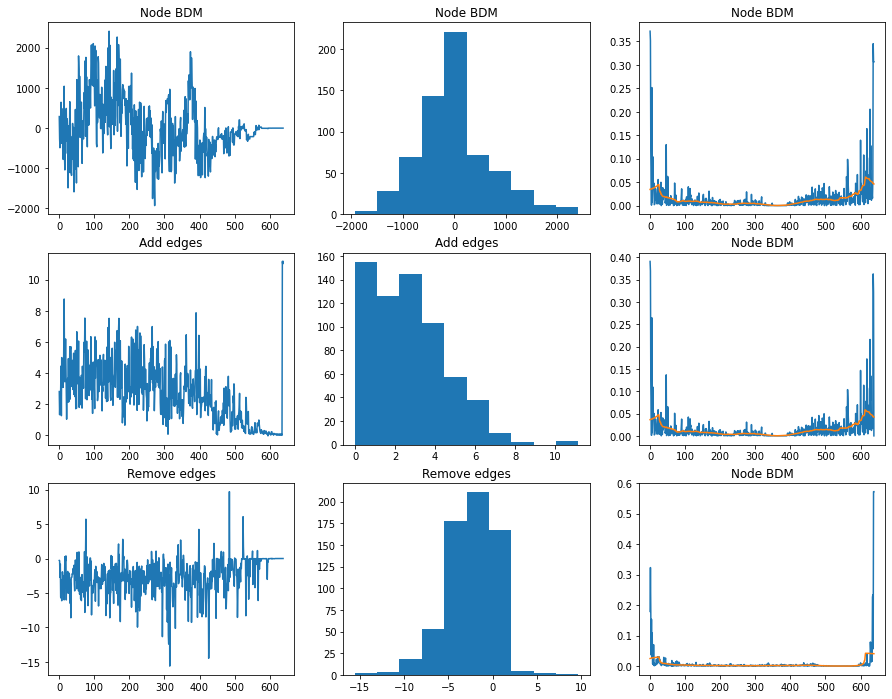

In [46]:
figure(figsize=[15,12])
subplot(3,3,1)
plot(sim_nodes)
title('Node BDM')
subplot(3,3,2)
hist(sim_nodes)
title('Node BDM')
subplot(3,3,3)
#plot(srt_nodes)
plot(dy_nodes)
plot(conv_dy_nodes)
title('Node BDM')
subplot(3,3,4)
plot(sim_add)
title('Add edges')
subplot(3,3,5)
hist(sim_add)
title('Add edges')
subplot(3,3,6)
#plot(srt_add)
plot(dy_add)
plot(conv_dy_add)
title('Node BDM')
subplot(3,3,7)
plot(sim_rem)
title('Remove edges')
subplot(3,3,8)
hist(sim_rem)
title('Remove edges')
subplot(3,3,9)
#plot(srt_rem)
plot(dy_rem)
plot(conv_dy_rem)
title('Node BDM')

1. Biological meaning of adding edges
2. How to calculate thresholds
    Filtering?

In [23]:
down_threshold = -500
up_threshold = 500

In [24]:
neg = nodebdm_ppi<down_threshold
pos = nodebdm_ppi>up_threshold

In [25]:
bin_nodebdm_ppi = neg.astype(int)*-1+pos.astype(int)

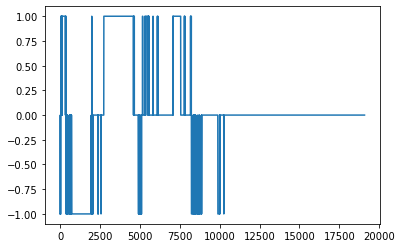

In [26]:
plot(bin_nodebdm_ppi)

# Create random symmetric adj matrix

In [ ]:
# test random adj matrix
s = 100
b = np.random.randint(0,2,size=[s,s])
sym = np.floor((b+b.T)/2).astype(int)
sym[:,3] = np.zeros(s)
sym[3,:] = np.zeros(s)
ppi_adj = sp.csc_matrix(sym)
print(np.count_nonzero(sym))

## Revisar si adj mats contienen el 1 en la diagonal

In [ ]:
with open('data/data_structures/DS/DS_real_DSE_9700_genes_16837_drugs_636_se_7','rb') as f:
    DS = pickle.load(f)
    for key in DS.keys():
        globals()[key]=DS[key]
        print(key,"Imported successfully")

In [ ]:
ddi_adj_list[0].todense()

# TWOSIDES

In [ ]:
DF = pd.read_csv('../Thesis_datasets/TWOSIDES/small.csv',sep=',',usecols=[0,1,2,3,4,5])
DEC = pd.read_csv('data/original_data/bio-decagon-combo.csv',sep=',')

In [ ]:
DEC.head()

In [ ]:
DF.head(10)

### Transform Dictionaries Side effects
`meddra.tsv` is a database that contains names of side effects in both wanted ids

In [ ]:
map_se = pd.read_csv('../Thesis_datasets/SIDER/meddra.tsv', sep = '\t'\
                     ,header=None).rename(columns={0:'UMLS',1:'kind',2:'MedDRA',3:'name'})
cui = pd.unique(map_se['UMLS'].values)
meddra = pd.unique(map_se['MedDRA'].values)
ses = pd.unique(map_se['name'].values)
print('Total',len(map_se))
print('CUI',len(cui))
print('MedDRA',len(meddra))
print('Side Effects',len(ses))
map_se.head(5)

In [ ]:
# Dictionary that translates UMLS CUIs to MedDRA IDs
umls2meddra = defaultdict(set)
for se in map_se.index:
    umls2meddra[map_se.loc[se,'UMLS']] = map_se.loc[se,'MedDRA']
# Dictionary that translates MedDRA IDs to UMLS CUIs
meddra2umls = defaultdict(set)
for se in map_se.index:
    meddra2umls[map_se.loc[se,'MedDRA']] = map_se.loc[se,'UMLS']
# Dictionary that translates UMLS CUIs to name
names = map_se[map_se['kind'].str.match('PT',na=False)].reset_index(drop=True)
print(len(names.index))
UMLS2names = {}
for se in names.index:
    UMLS2names[names.loc[se,'UMLS']] = names.loc[se,'name']
# Verify numbers
print(len(umls2meddra))
print(len(meddra2umls))
print(len(UMLS2names))

In [ ]:
# Dictionary that translates UMLS CUIs to name
names = map_se[map_se['kind'].str.match('PT',na=False)].reset_index(drop=True)
print(len(names.index))
UMLS2names = {}
for se in names.index:
    UMLS2names[names.loc[se,'UMLS']] = names.loc[se,'name']
print(len(UMLS2names))

### Replacing 

In [ ]:
ids = []
for i in DF['condition_meddra_id']:
    ids.append(meddra2umls[i])
DF['Condition'] = ids
DF = DF.drop(columns=['condition_meddra_id'])
name_list = []
for i in DF['Condition']:
    name_list.append(UMLS2names[i])
DF['Condition_name'] = name_list
DF = DF.drop(columns=['condition_concept_name'])
DF.head(10)

In [ ]:
map_drug = pd.read_csv('../Thesis_datasets/SIDER/drug_names.tsv',sep = '\t',header=None)

In [ ]:
map_drug.head()

## Testing fixed unigram candidate sampler found in optimization

In [ ]:
sess = tf.Session()
a = [7,0,20,8,33,9]
labels = tf.reshape(tf.constant(a,dtype=tf.int64),[6,1])
sampled_ids, true_expected_count, sampled_expected_count = tf.nn.fixed_unigram_candidate_sampler(
   true_classes = labels,
   num_true = 1,
   num_sampled = 20,
   unique = False,
   range_max = np.shape(a)[0],
   unigrams = [ 10, 10, 10, 10, 50, 10 ]
)
sample = tf.gather( labels, sampled_ids )
print(sess.run( true_expected_count ))
print(sess.run( sampled_ids ))
print(sess.run( sampled_expected_count ))
print(sess.run( sample ))

In [ ]:
in_file = 'data/data_structures/DECAGON/DECAGON_real_affinities_genes_16814_drugs_276_se_7'
with open(in_file, 'rb') as f:
    DS = pickle.load(f)
    for key in DS.keys():
        globals()[key]=DS[key]
        print(key,"Imported successfully")

In [ ]:
adj_mats_orig[1,0][0].todense().sum()

In [ ]:
val_metrics[0,:,:]

In [ ]:
%pylab inline

In [ ]:
pd.read_csv('../Thesis_datasets/DrugBank/drugbank_all_full_database.xml/full database.xml')